# P2I7 - Le pendule double

**Projet mené par :** Lomenech Nathan, Gagou Mattéo, Roche Nathan, Mauclaire Alexis

<img src="pendule_double.gif" alt="Texte alternatif" style="width:400px;height:400px;">

## Table des matières : 
1. Simulation du pendule double aux faibles angles
2. Intégration des équations du mouvement non linéaires, analyse de la réponse en fonction des conditions initiales
3. Détermination de l’angle critique à partir duquel le mouvement devient chaotique
4. Applications aux problèmes réels (théorie du Chaos et mécanique non linéaire)

## 1. Simulation du pendule aux petits angles

### Solution analytique aux petits angles :

On a le système suivant :

$\hspace{3cm} 
\begin{cases} 
(m_1 + m_2)l_1^2 \ddot{\theta}_1 + m_2l_1l_2\ddot{\theta}_2 + (m_1 + m_2)gl_1\theta_1 = 0
\\ 
m_2l_1l_2\ddot{\theta}_2 + m_2l_2^2\ddot{\theta}_2 + m_2gl_2\theta_2 = 0
\end{cases}$


Nous allons utilisé la version suivante : 

$\hspace{3cm} 
\begin{cases} 
\ddot{\theta}_1 = \frac{\mu g\theta_2 - (1+\mu)g\theta_1}{l_1}
\\ 
\ddot{\theta}_2 = \frac{(1+\mu)g \theta_1 - (1+\mu)g\theta_2}{l_2}
\end{cases}$

Avec la solution analytique exacte : 

$\hspace{3cm} 
\begin{cases} 
\theta_1^{exact}(t) = C_1 \cos(\omega_1t + \phi_1) + C_2 \cos(\omega_2t + \phi_2)
\\
\theta_2^{exact}(t) = C_2 A_1 \cos(\omega_1t + \phi_1)+C_2 A_2 \cos(\omega_2 t + \phi_2)
\end{cases}$

avec : 

$$ \omega_{1,2}^2 = \frac{g(1+ \mu)(l_1+l_2) \pm g\sqrt{(1+\mu)^2(l_1+l_2)^2 - 4(1+\mu)l_1l_2}}{2l_1l_2} $$


#### Importations :

In [1]:
import math 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import  matplotlib.animation as animation
from numpy.linalg import inv, norm
from matplotlib.pyplot import figure, gca, xlim, show
from scipy.integrate import solve_ivp

#### Les différentes variables : 
 - solution_ana : **solution analytique aux petits angles**, array 2D avec [$\theta_1$,$\theta_2$, $\dot{\theta_1}$,$\dot{\theta_1}$]
 - solution_ivp : **solution obtenu avec solve.ivp** array 2D avec [$\theta_1$,$\theta_2$, $\dot{\theta_1}$,$\dot{\theta_1}$]
 - solution_newmark :  **solution obtenu avec l'algorithme de Newmark** array 2D avec [$\theta_1$,$\theta_2$, $\dot{\theta_1}$,$\dot{\theta_1}$]

#### Définition des conditions initiales :

In [29]:
theta10 = 0.1                            #theta 1 initial (rad)
theta20 = 0.1                            #theta 2 initial (rad)
omega10 = 0.1                              #omega 1 initial (rad/s)
omega20 = 0.02                              #omega 2 initial (rad/s)
l1 = 3                                #longeur du premier bras (m)
l2 = 2                                #longeur du deuxième bras (m)
g = 9.81                                #Acceleration terrestre (m.s^-2)
tf = 3                                 #temps de la simulation (s)
dt = 0.01                               #Pas temporel (s)
Ninc = int(tf/dt)                       #nombre d'itération
m1 = 2
m2 = 3
mu = m2/m1

t0 = 0
x0 = np.array([theta10,theta20, omega10, omega20]) #creation
t_balayage = np.linspace(t0, tf, Ninc)  #avec t_balayage2 = np.arange(t0, tf, dt) on n'atteint pas tf .. 

#### On utilise le schéma suivant pour la nomenclature des angles et longeurs :
<img src="schema.png" alt="Texte alternatif" style="width:300px;height:300px;">

#### Calcul de la solution analytique

In [36]:
#création des variables
solution_ana= np.zeros((4,Ninc))

#cacul des constantes
omega1_carre = (g*(1+mu)*(l1+l2) + g*np.sqrt((1+mu)**2*(l1+l2)**2 - 4*(1+mu)*l1*l2)/(2*l1*l2))
omega2_carre = (g*(1+mu)*(l1+l2) - g*np.sqrt((1+mu)**2*(l1+l2)**2 - 4*(1+mu)*l1*l2)/(2*l1*l2))
    
A1 = (1+mu)/mu - l1/(mu*g)*omega1_carre
A2 = (1+mu)/mu - l1/(mu*g)*omega2_carre

C1 = (theta20 - A2*theta10)/(A1-A2)
C2 = (A1*theta10 - theta20)/(A1-A2)

phi1 = np.arcsin((omega20-A2*omega10)/(C1*np.sqrt(omega1_carre)*(A2-A1)))
phi2 = np.arcsin((A1*omega10-omega20)/(C2*np.sqrt(omega2_carre)*(A2-A1)))


for t in range(Ninc):
    solution_ana[0,t] = C1*np.cos(np.sqrt(omega1_carre)*t*dt + phi1) + C2*np.cos(np.sqrt(omega2_carre)*t*dt + phi2)
    solution_ana[1,t] = C1*A1*np.cos(np.sqrt(omega1_carre)*t*dt + phi1) + C2*A2*np.cos(np.sqrt(omega2_carre)*t*dt + phi2)

#CALCUL des dérivées temporelles : 
for j in range(Ninc):
    
    if j == 0 :
        #calcul pour omega1
        solution_ana[2,j] = (-3*solution_ana[0,j] + 4*solution_ana[0, j+1] - solution_ana[0,j+2])/(2*dt)
        #calcul pour omega2
        solution_ana[3,j] = (-3*solution_ana[1,j] + 4*solution_ana[1, j+1] - solution_ana[1,j+2])/(2*dt)
    
    elif j == Ninc-1 :
        #calcul pour omega1
        solution_ana[2,j] = (3*solution_ana[0,j] - 4*solution_ana[0, j-1] + solution_ana[0,j-2])/(2*dt)
        #calcul pour omega2
        solution_ana[3,j] = (3*solution_ana[1,j] - 4*solution_ana[1, j-1] + solution_ana[1,j-2])/(2*dt)    
    
    else:
        #calcul pour omega1
        solution_ana[2,j] = (solution_ana[0,j+1] - solution_ana[0, j-1])/(2*dt)
        #calcul pour omega2
        solution_ana[3,j] = (solution_ana[1,j+1] - solution_ana[1, j-1] )/(2*dt)    
    

#### Résolution numérique avec solve IVP (à revoir)

In [22]:
def pendule_double_ivp(t, X, l1, l2, g,mu):
    theta1, omega1, theta2, omega2 = X
    
    dtheta1dt = omega1
    domega1dt = (mu*g*theta2 - (1+mu)*g*theta1)/l1
    dtheta2dt = omega2
    domega2dt = ((1+mu)*g*theta1 - (1 + mu)*g*theta2)/l2
    
    
    return [dtheta1dt, domega1dt, dtheta2dt, domega2dt]

In [23]:
solution_ivp=solve_ivp(pendule_double_ivp, [t0,tf], x0, method='RK45', args = (l1, l2, g, mu), t_eval=t_balayage)

#### Résolution numérique avec Newmark

##### Définition des fonctions

In [6]:
def calc_P(p0,OMEGA,t):
    P=p0*np.cos(OMEGA*t)
    return P

def calc_Fnl(knl,X,dX):
    Fnl=knl*X**3
    return Fnl

def calc_dFnl(knl,X,dX):
    dFX=3*knl*X**2
    dFdX=0
    return dFX,dFdX

##### Algorithme de Newmark

In [7]:
def Newmark(X0,dX0,t_init,dt,NT):
    precNR=1.e-9
    # C.I. déplacement et vitesse
    t=t_init
    X=X0;dX=dX0
    # initialisation des variables
    Fnl=0
    dFX=0
    dFdX=0
    P=0
    # tableaux de stockage des résultats à chaque pas de temps
    tt=zeros((NT,1))         # temps
    Xt=zeros((NT,1))      # déplacement
    dXt=zeros((NT,1))     # vitesse
    
    P=calc_P(p0,OMEGA,t)     # calcul de l'effort extérieur
    Fnl=calc_Fnl(knl,X,dX)   # calcul de l'effort non-linéaire
    ddX=(P-C*dX-K*X-Fnl)/M   # accélération initiale
    tt[0]=t
    Xt[0]=X
    dXt[0]=dX
    
    # Boucle sur les pas de temps
    for n in range(1,NT):
        t=t+dt;
        # prediction
        iter=0;
        X=X+dt*dX+(dt**2/2)*ddX
        dX=dX+dt*ddX
        ddX=ddX
        # Calcul du residu
        P=calc_P(p0,OMEGA,t)
        Fnl=calc_Fnl(knl,X,dX)
        res=P-M*ddX-C*dX-K*X-Fnl
        normres=abs(res/P)
        # Iterations de Newton Raphson
        while (normres>precNR):
            iter=iter+1
            # Calcul de la Jacobienne
            dFX,dFdX=calc_dFnl(knl,X,dX)
            J=(4/dt**2)*M+(2/dt)*(C+dFdX)+K+dFX
            # Calcul de la correction
            deltaX=res/J
            X=X+deltaX
            # mise à jour vitesse et accélération
            dX=dX+(2/dt)*deltaX
            ddX=ddX+(4/dt**2)*deltaX
            # Calcul du residu
            Fnl=calc_Fnl(knl,X,dX)
            res=P-M*ddX-C*dX-K*X-Fnl
            #normres=abs(res/P)
            normres=abs(deltaX/X)
        tt[n]=t     # stockage t(n)
        Xt[n]=X     # stockage X(n)
        dXt[n]=dX   # stockage dX(n)
    return tt,Xt,dXt

##### Paramétrage du système

##### Résolution

In [8]:
OMEGA=1.
X0=1;dX0=0             # conditions initiales
start = time.process_time()
tt,Xt,dXt=Newmark(X0,dX0,t_init,dt,NT)   # Integration par Newmark
print('ellapsed time: ',time.process_time() - start)


NameError: name 'time' is not defined

#### Tracé des angles en fonction du temps

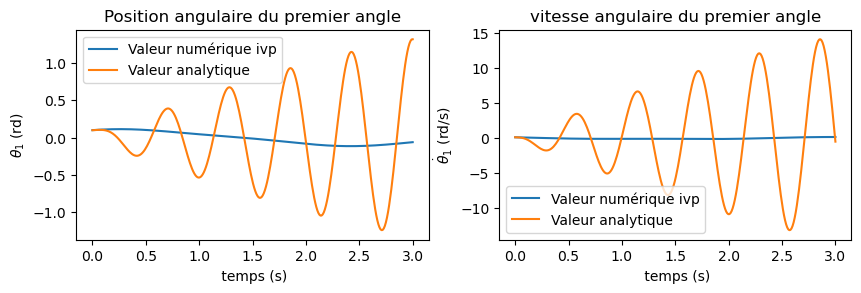

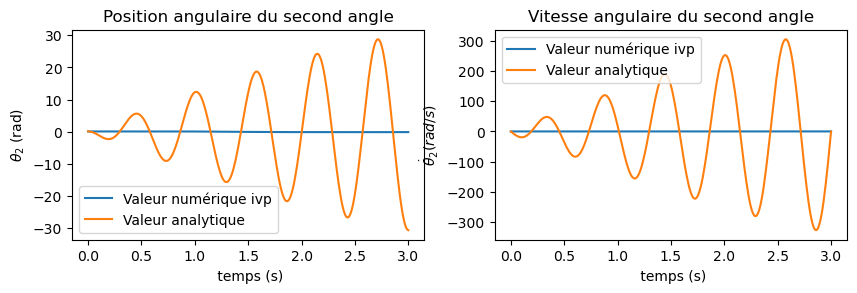

In [37]:
fig = plt.figure(figsize=(10, 6));

ax = fig.add_subplot(2,2,1);
ax.plot(solution_ivp.t,solution_ivp.y[0], label = 'Valeur numérique ivp');
ax.plot(t_balayage,solution_ana[0,:], label = 'Valeur analytique');
ax.set_xlabel(' temps (s)')
ax.set_ylabel(r'$ \theta_1 $ (rd)')
ax.set_title('Position angulaire du premier angle')
plt.legend()

bx = fig.add_subplot(2,2,2);
bx.set_xlabel(' temps (s)')
bx.set_ylabel(r'$ \dot\theta_1 $ (rd/s)')
bx.set_title('vitesse angulaire du premier angle')
bx.plot(solution_ivp.t,solution_ivp.y[1],label = 'Valeur numérique ivp')
bx.plot(t_balayage,solution_ana[2,:], label = 'Valeur analytique')
plt.legend()

fig = plt.figure(figsize=(10, 6));

cx = fig.add_subplot(2,2,3);
cx.set_xlabel(' temps (s)')
cx.set_ylabel(r'$ \theta_2$ (rad)')
cx.set_title('Position angulaire du second angle')
cx.plot(solution_ivp.t,solution_ivp.y[2], label = 'Valeur numérique ivp')
cx.plot(t_balayage,solution_ana[1,:], label = 'Valeur analytique')
plt.legend()

dx = fig.add_subplot(2,2,4);
dx.set_xlabel(' temps (s)')
dx.set_ylabel(r'$ \dot{\theta}_2 (rad/s) $')
dx.set_title('Vitesse angulaire du second angle')
dx.plot(solution_ivp.t,solution_ivp.y[3], label = 'Valeur numérique ivp')
dx.plot(t_balayage,solution_ana[3,:], label = 'Valeur analytique')

plt.legend()


## 